# 1. Setup

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import csv
from itertools import zip_longest
import math

In [2]:
# Import Dependencies for face detection and MTCNN Model
from numpy import asarray
from PIL import Image

In [3]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, ZeroPadding2D, Convolution2D, Dropout, Activation


In [4]:
#Import Preprocessing packages
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import asarray

In [5]:
# VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16

In [6]:
SEED = 21

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[0], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass


# 3. Load and Preprocess Images

## 3.1 Preprocessing - Alignment and Cropping

In [ ]:
def preprocess(file_path, required_size=(224,224)):
    raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(raw, channels=3, dct_method='INTEGER_ACCURATE')
    image = tf.image.resize(image,required_size, method='nearest')
    image = tf.cast(image, 'float32')
    return np.array(image)

In [ ]:
def complete_preprocess(image_path, required_size=(224,224)): 
    # load image and detect the face
    image = preprocess(image_path)
    
    #Preprocessing
    face_array = preprocess_input(image)
    
    
    # Scale image to be between 0 and 1 
    face_array = (face_array - np.amin(face_array)) / (np.amax(face_array) - np.amin(face_array))
    # Scale image to be between -1 and 1
    face_array = 2*face_array - 1
    
    return tf.convert_to_tensor(face_array)

# 3.2 Create Labelled Dataset

In [ ]:
#df = pd.read_csv('cross_validation_data/siamese_training_data_cv_1.csv')
df = pd.read_csv('cross_validation_data/siamese_testing_data_1.csv')

anchor_array = df.anchor.to_list()
full_array = df.other_image.to_list()
binary_array = df.binary.to_list()
anchor_label = df.anchor_label.to_list()
other_image_labels = df.other_image_label.to_list()

In [ ]:
data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(anchor_array)
                            ,tf.data.Dataset.from_tensor_slices(full_array), 
                            tf.data.Dataset.from_tensor_slices(binary_array),
                            tf.data.Dataset.from_tensor_slices(anchor_label),
                            tf.data.Dataset.from_tensor_slices(other_image_labels)
                           ))


# 3.3 Build Train and Test Partition

In [ ]:
def preprocess_twin(anchor_img, other_img, label, a_lable, o_label):
    return(complete_preprocess(anchor_img), complete_preprocess(other_img), label)

In [ ]:
# Build dataloader pipeline
data = data.map(lambda x, y, z, a, b: tf.py_function(preprocess_twin, inp = (x, y, z, a, b), Tout=(tf.float32, tf.float32, tf.int32)))
#data = data.cache()
data = data.shuffle(buffer_size=1024, seed = SEED)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*0.8)) 
train_data = train_data.batch(16)

In [ ]:
# Testing data
test_data = data.take(round(len(data)*1))
test_data = test_data.batch(16)

# 4. Evaluate Model

In [ ]:
#Graphing loss

df = pd.read_csv('cross_validation_results_copy/siamese_training_facenet_cv_no_hard_sampling_5.csv')
df[['epoch', 't_loss', 'v_loss']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='Loss',
    title='Training Loss VS Validation_Loss Iteration 5'
)

plt.show()

In [ ]:
#Graphing accuracy

df = pd.read_csv('cross_validation_results_copy/siamese_training_facenet_cv_no_hard_sampling_5.csv')
df[['epoch', 't_acc', 'v_acc']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='Binary Accuracy',
    title='Training Accuracy VS Validation Accuracy Iteration 5'
)

plt.show()

## 6.3 Calculate Metrics

In [9]:
def evaluate_non_siamese(positive_distances,negative_distances):
    #Find threshold
    #positive_distance is the list of euclidean distances from the positive tests, and vice versa for the ngative tests
    pos_list = positive_distances
    neg_list = negative_distances

    pos_avg = min(min(pos_list), min(neg_list))
    #pos_avg = pos_avg[0][0]

    neg_avg = max(max(pos_list), max(neg_list))
    #neg_avg = neg_avg[0][0]

    max_threshold = 0
    max_preditions = 0

    #Step size for increments
    theta = abs(pos_avg-neg_avg)/100


    new_threshold = pos_avg
    
    
    size = 102
    tp_array =  np.zeros(size)
    fn_array =  np.zeros(size) 
    tn_array =  np.zeros(size) 
    fp_array =  np.zeros(size)

    iteration = 0

    #We iterate through pos_avg to neg_avg by an increment of theta in this loop 
    #At each iteration we check how many correct predictions are made in total and record the threshold if the 
    #number of correct predictions is higher than before
    while 1:
        correct_predictions = 0

        #Checking all the positive distances that are smaller than the threshold (correct positive prediction)
        c_pos = 0
        for p in pos_list:
            if new_threshold > p:
                c_pos = c_pos + 1
        correct_predictions = c_pos

        #Checking all the positive distances that are greater than the threshold (correct negative prediction)
        c_neg = 0
        for n in neg_list:
            if new_threshold  <= n:
                c_neg = c_neg + 1

        correct_predictions = correct_predictions + c_neg

        #https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
        tp_array[iteration] =  c_pos
        fn_array[iteration] =  len(pos_list)-c_pos
        tn_array[iteration] =  c_neg
        fp_array[iteration] =  len(neg_list)-c_neg

            
        #This is just used to check if the number of correct predicitons are greater than previous iterations
        #If it is then we record the current threshold as the most accurate threshold
        if max_preditions <= correct_predictions:
            max_preditions = correct_predictions
            max_threshold = new_threshold

        #Reached the end of the loop
        if new_threshold > neg_avg:
            break
            
        #Incrementing the current threshold
        new_threshold = new_threshold + theta
        iteration = iteration + 1
    
    return max_threshold, tp_array, fn_array, tn_array, fp_array



In [10]:
def calculate_accuracy(max_threshold,pos_list,neg_list):
    correct_predictions = 0
    total_predictions = len(pos_list) + len(neg_list)

    c_pos = 0
    for p in pos_list:
        if max_threshold > p:
            c_pos = c_pos + 1
    correct_predictions = c_pos

    c_neg = 0
    for n in neg_list:
        if max_threshold <= n:
            c_neg = c_neg + 1

    correct_predictions = correct_predictions + c_neg


    accuracy = correct_predictions/ total_predictions


    TP = c_pos
    FN = len(pos_list)-c_pos
    TN = c_neg
    FP = len(neg_list)-c_neg

    print("Actual: POSITIVE, Predicted: POSITIVE: {}".format(c_pos))
    print("Actual: POSITIVE, Predicted: NEGATIVE: {}".format(len(pos_list)-c_pos))
    print("Actual: NEGATIVE, Predicted: NEGATIVE: {}".format(c_neg))
    print("Actual: NEGATIVE, Predicted: POSITIVE: {}".format(len(neg_list)-c_neg))
    
    F1 = (TP)/(TP+0.5*(FP+FN))

    print("correct: {} total: {} accuracy: {}, F1: {}".format(correct_predictions,total_predictions, accuracy, F1))


# Calculate Metrics for Siamese Network

In [544]:
THRESHOLD_STEP = 0.01

In [545]:
def evaluate_siamese(positive_distances,negative_distances):
    #Find threshold
    #positive_distance is the list of euclidean distances from the positive tests, and vice versa for the ngative tests
    pos_list = positive_distances
    neg_list = negative_distances

    #pos_avg = max(max(pos_list), max(neg_list))
    pos_avg = 1

    #neg_avg = min(min(pos_list), min(neg_list))
    neg_avg = 0

    max_threshold = 0
    max_preditions = 0

    #Step size for increments
    theta = THRESHOLD_STEP


    new_threshold = neg_avg
    
    size = int(pos_avg/THRESHOLD_STEP)+1
    tp_array =  np.zeros(size)
    fn_array =  np.zeros(size) 
    tn_array =  np.zeros(size) 
    fp_array =  np.zeros(size)

    #We iterate through pos_avg to neg_avg by an increment of theta in this loop 
    #At each iteration we check how many correct predictions are made in total and record the threshold if the 
    #number of correct predictions is higher than before
    iteration = 0
    while 1:
        correct_predictions = 0

        #Checking all the positive distances that are greater than the threshold (correct positive prediction)
        c_pos = 0
        for p in pos_list:
            if new_threshold < p:
                c_pos = c_pos + 1
        correct_predictions = c_pos



        #Checking all the positive distances that are smaller than the threshold (correct negative prediction)
        c_neg = 0
        for n in neg_list:
            if new_threshold  >= n:
                c_neg = c_neg + 1

        correct_predictions = correct_predictions + c_neg

        #https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
        TP = c_pos
        FN = len(pos_list)-c_pos
        TN = c_neg
        FP = len(neg_list)-c_neg
        
        
        tp_array[iteration] =  c_pos
        fn_array[iteration] =  len(pos_list)-c_pos
        tn_array[iteration] =  c_neg
        fp_array[iteration] =  len(neg_list)-c_neg


        #This is just used to check if the number of correct predicitons are greater than previous iterations
        #If it is then we record the current threshold as the most accurate threshold
        if max_preditions <= correct_predictions:
            max_preditions = correct_predictions
            max_threshold = new_threshold

        #Reached the end of the loop
        if new_threshold > pos_avg:
            break
            
        #Incrementing the current threshold
        new_threshold = new_threshold + theta
        
        iteration = iteration + 1

    
    return max_threshold, tp_array, fn_array, tn_array, fp_array

In [546]:
def calculate_accuracy_siamese(max_threshold,pos_list,neg_list):
    correct_predictions = 0
    total_predictions = len(pos_list) + len(neg_list)

    c_pos = 0
    for p in pos_list:
        if max_threshold < p:
            c_pos = c_pos + 1
    correct_predictions = c_pos

    c_neg = 0
    for n in neg_list:
        if max_threshold >= n:
            c_neg = c_neg + 1

    correct_predictions = correct_predictions + c_neg


    accuracy = correct_predictions/ total_predictions

    
    TP = c_pos
    FN = len(pos_list)-c_pos
    TN = c_neg
    FP = len(neg_list)-c_neg

    print("Actual: POSITIVE, Predicted: POSITIVE: {}".format(c_pos))
    print("Actual: POSITIVE, Predicted: NEGATIVE: {}".format(len(pos_list)-c_pos))
    print("Actual: NEGATIVE, Predicted: NEGATIVE: {}".format(c_neg))
    print("Actual: NEGATIVE, Predicted: POSITIVE: {}".format(len(neg_list)-c_neg))
    
    F1 = (TP)/(TP+0.5*(FP+FN))

    print("correct: {} total: {} accuracy: {}, F1: {}".format(correct_predictions,total_predictions, accuracy, F1))

In [547]:
range_n = 6

In [618]:
size = int(1/THRESHOLD_STEP)+1
tp_array =  np.zeros(size)
fn_array =  np.zeros(size) 
tn_array =  np.zeros(size) 
fp_array =  np.zeros(size)

for i in range(1,range_n):
    #Load distances
    file_name = 'cross_validation_results/demonstration/demonstration_not_straight_faces_data_distances_facenet_no_mining_cv_'+str(i)+'.csv'
    
    #file_name = 'cross_validation_results/5pp/train_data_distances_5pp_facenet_no_mining_cv_'+str(i)+'.csv'
    df = pd.read_csv(file_name, )
    positive_distances = df.positive_distances.to_list()
    negative_distances = df.negative_distances.to_list()
    
    #Get rid of nan values!!!!!!!!
    positive_distances = [x for x in positive_distances if math.isnan(x) == False]
    negative_distances = [x for x in negative_distances if math.isnan(x) == False]
    
    #positive_distances = [item for item in positive_distances if not(pd.isnull(item)) == True]
    #negative_distances = [item for item in negative_distances if not(pd.isnull(item)) == True]
    
    max_threshold, tp_array1, fn_array1, tn_array1, fp_array1 = evaluate_siamese(positive_distances,negative_distances)
    #TPR_list, FPR_list, pre_list, rec_list, max_threshold = evaluate_non_siamese(positive_distances,negative_distances)
    
    
    tp_array =  np.add(tp_array, tp_array1)  
    fn_array =  np.add(fn_array, fn_array1)   
    tn_array =  np.add(tn_array, tn_array1)   
    fp_array =  np.add(fp_array, fp_array1)  
    
print(tp_array)
print(fn_array)
print(tn_array)
print(fp_array)
    
    

[320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320.
 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320.
 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320.
 319. 319. 318. 318. 318. 318. 316. 316. 316. 314. 314. 314. 314. 313.
 313. 313. 313. 313. 313. 312. 312. 311. 311. 310. 310. 310. 310. 310.
 309. 307. 307. 305. 304. 304. 302. 301. 301. 301. 301. 300. 299. 299.
 295. 292. 291. 289. 286. 284. 278. 276. 270. 265. 262. 255. 250. 240.
 230. 192.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   1.   2.   2.   2.   2.   4.   4.   4.   6.   6.   6.   6.   7.
   7.   7.   7.   7.   7.   8.   8.   9.   9.  10.  10.  10.  10.  10.
  11.  13.  13.  15.  16.  16.  18.  19.  19.  19.  19.  20.  21.  21.
  25.  28.  29.  31.  34.  36.  42.  44.  50.  55.  58.  65.

In [612]:
size = 102
tp_array2 =  np.zeros(size)
fn_array2 =  np.zeros(size) 
tn_array2 =  np.zeros(size) 
fp_array2 =  np.zeros(size)

for i in range(1,range_n):
    #Load distances
    file_name = 'cross_validation_results/alone/vgg_alone_train_'+str(i)+'.csv'
    df = pd.read_csv(file_name, )
    positive_distances = df.positive_distances.to_list()
    negative_distances = df.negative_distances.to_list()
    
    #Get rid of nan values!!!!!!!!
    positive_distances = [x for x in positive_distances if math.isnan(x) == False]
    negative_distances = [x for x in negative_distances if math.isnan(x) == False]
    
    max_threshold, tp_array1, fn_array1, tn_array1, fp_array1 = evaluate_non_siamese(positive_distances,negative_distances)
    #TPR_list, FPR_list, pre_list, rec_list, max_threshold = evaluate_non_siamese(positive_distances,negative_distances)
    
    
    tp_array2 =  np.add(tp_array2, tp_array1)  
    fn_array2 =  np.add(fn_array2, fn_array1)   
    tn_array2 =  np.add(tn_array2, tn_array1)   
    fp_array2 =  np.add(fp_array2, fp_array1)  
    
print(tp_array2)
print(fn_array2)
print(tn_array2)
print(fp_array2)
    
    

[0.0000e+00 1.1000e+01 1.5000e+01 2.3000e+01 2.7000e+01 3.2000e+01
 5.0000e+01 6.5000e+01 8.9000e+01 1.2100e+02 1.5900e+02 2.1400e+02
 2.8100e+02 3.6700e+02 4.8700e+02 6.0600e+02 7.5700e+02 9.3600e+02
 1.1630e+03 1.4500e+03 1.7560e+03 2.1250e+03 2.5560e+03 3.0530e+03
 3.5820e+03 4.2060e+03 4.9020e+03 5.6150e+03 6.4720e+03 7.3640e+03
 8.2840e+03 9.2380e+03 1.0283e+04 1.1368e+04 1.2562e+04 1.3663e+04
 1.4851e+04 1.5943e+04 1.7019e+04 1.8091e+04 1.9259e+04 2.0244e+04
 2.1226e+04 2.2138e+04 2.2995e+04 2.3832e+04 2.4592e+04 2.5375e+04
 2.5999e+04 2.6625e+04 2.7126e+04 2.7631e+04 2.8024e+04 2.8413e+04
 2.8706e+04 2.8984e+04 2.9278e+04 2.9475e+04 2.9669e+04 2.9852e+04
 2.9995e+04 3.0125e+04 3.0227e+04 3.0341e+04 3.0417e+04 3.0477e+04
 3.0532e+04 3.0578e+04 3.0626e+04 3.0664e+04 3.0695e+04 3.0723e+04
 3.0753e+04 3.0769e+04 3.0785e+04 3.0803e+04 3.0815e+04 3.0828e+04
 3.0835e+04 3.0843e+04 3.0853e+04 3.0857e+04 3.0858e+04 3.0861e+04
 3.0862e+04 3.0867e+04 3.0870e+04 3.0871e+04 3.0872e+04 3.0874

In [565]:
#Print confusion matrices
def print_confusion_matrices(tp,fn,tn,fp):
    for i in range(0, len(tp)):
        print("True Positives: {}  False Positives: {}".format(tp[i],fp[i]))
        print("False Negatives: {}  True Negatives: {}".format(fn[i],tn[i]))
        print("Threshold: {}".format(THRESHOLD_STEP*i))
        print()

In [566]:
print_confusion_matrices(tp_array,fn_array,tn_array,fp_array)

True Positives: 80.0  False Positives: 1200.0
False Negatives: 0.0  True Negatives: 0.0
Threshold: 0.0

True Positives: 80.0  False Positives: 445.0
False Negatives: 0.0  True Negatives: 755.0
Threshold: 0.01

True Positives: 80.0  False Positives: 328.0
False Negatives: 0.0  True Negatives: 872.0
Threshold: 0.02

True Positives: 80.0  False Positives: 277.0
False Negatives: 0.0  True Negatives: 923.0
Threshold: 0.03

True Positives: 80.0  False Positives: 240.0
False Negatives: 0.0  True Negatives: 960.0
Threshold: 0.04

True Positives: 80.0  False Positives: 218.0
False Negatives: 0.0  True Negatives: 982.0
Threshold: 0.05

True Positives: 80.0  False Positives: 196.0
False Negatives: 0.0  True Negatives: 1004.0
Threshold: 0.06

True Positives: 80.0  False Positives: 178.0
False Negatives: 0.0  True Negatives: 1022.0
Threshold: 0.07

True Positives: 80.0  False Positives: 162.0
False Negatives: 0.0  True Negatives: 1038.0
Threshold: 0.08

True Positives: 80.0  False Positives: 154.0


In [567]:
#There are cases where we have a NaN value at and index because of imbalance in data, we can remove those
def removeNanIndexes(array_1,array_2):
    #Removing nan indices
    remove_idx = []
    for r in np.argwhere(np.isnan(array_1)):
        remove_idx.append(r[0])

    for r in np.argwhere(np.isnan(array_2)):
        remove_idx.append(r[0])

    #Remove duplicate indexes
    remove_idx = list( dict.fromkeys(remove_idx))

    array_1 = np.delete(array_1,remove_idx)
    array_2 = np.delete(array_2,remove_idx)
    
    return array_1, array_2


### Calculating ROC curve

In [568]:
t = np.add(tp_array,fn_array)
tpr = np.divide(tp_array,t)
f = np.add(fp_array,tn_array)
fpr = np.divide(fp_array,f)

In [569]:
t2 = np.add(tp_array2,fn_array2)
tpr2 = np.divide(tp_array2,t2)
f2 = np.add(fp_array2,tn_array2)
fpr2 = np.divide(fp_array2,f2)

In [570]:
d = np.add(tp_array,fp_array)
pre = np.divide(tp_array,d)
d = np.add(tp_array,fn_array)
rec = np.divide(tp_array,d)

/home/athul/test/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [571]:
d = np.add(tp_array2,fp_array2)
pre2 = np.divide(tp_array2,d)
d = np.add(tp_array2,fn_array2)
rec2 = np.divide(tp_array2,d)

/home/athul/test/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [572]:
tpr, fpr = removeNanIndexes(tpr,fpr)

In [573]:
pre, rec = removeNanIndexes(pre,rec)

In [574]:
pre2, rec2 = removeNanIndexes(pre2,rec2)

In [575]:
model_name = 'FaceNet'

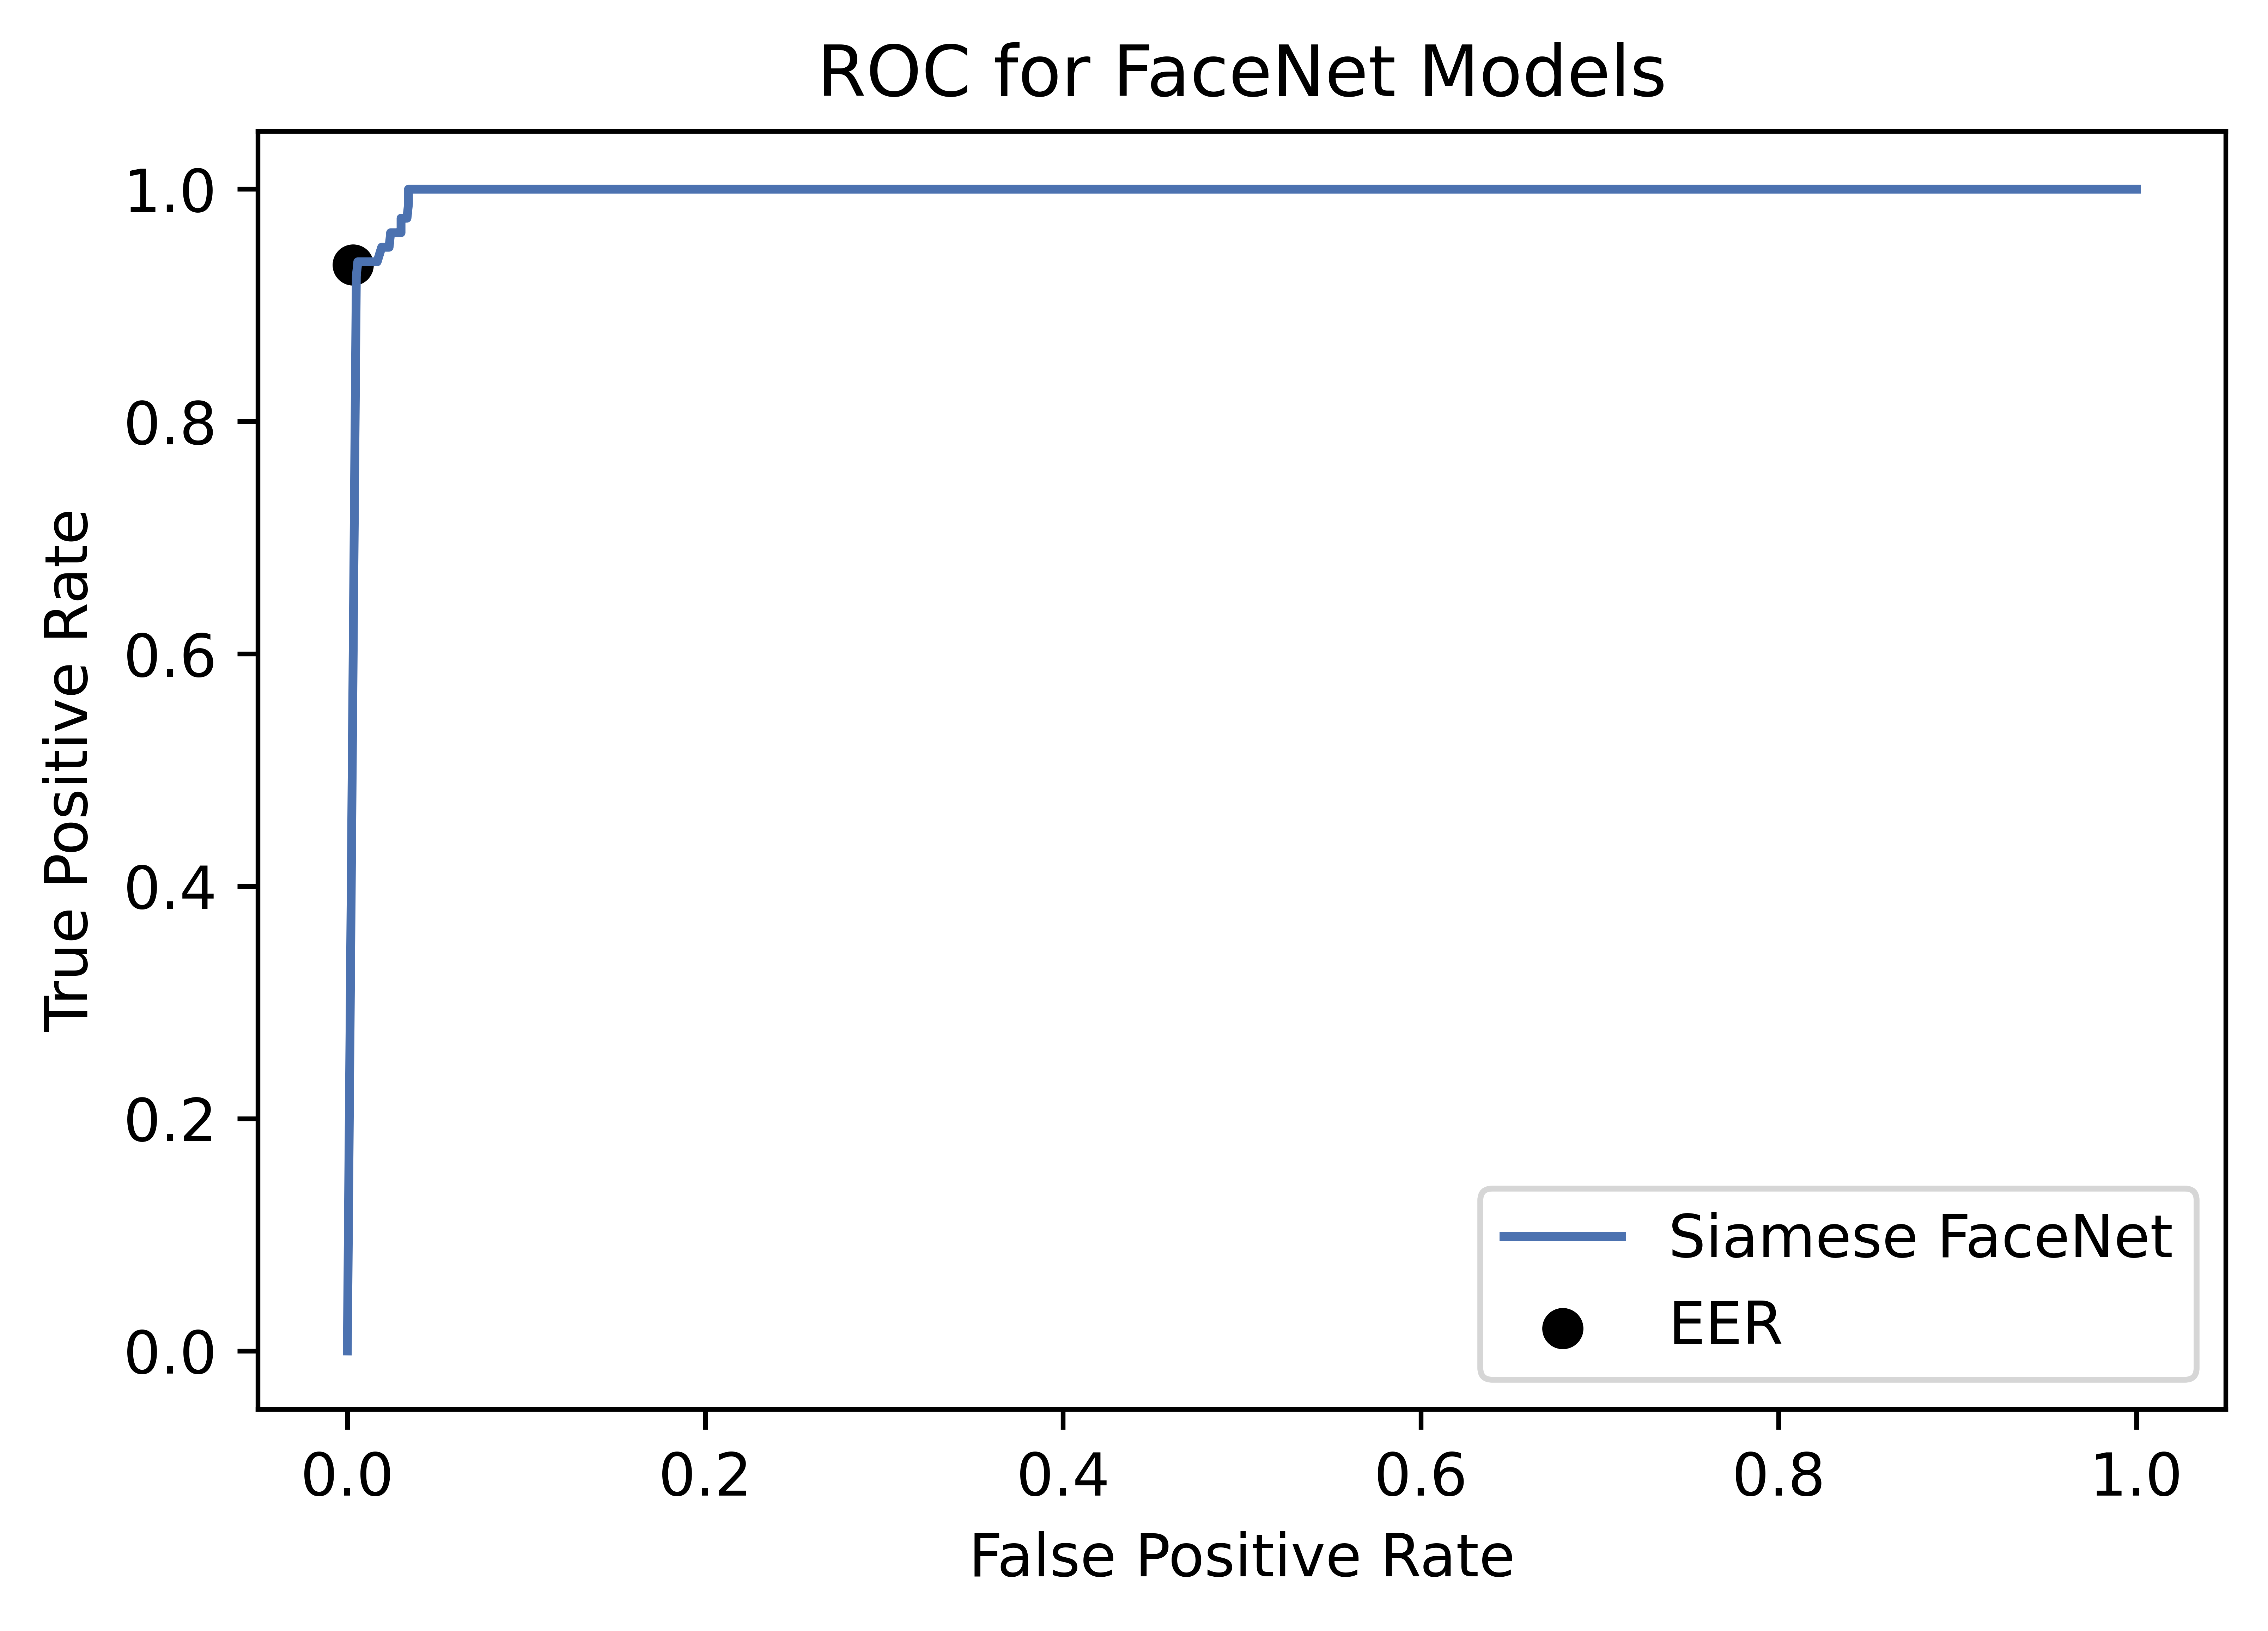

In [576]:
# plot lines
plt.figure(dpi = 1200)
plt.style.use('seaborn-deep')

name =  "Siamese "+model_name
plt.plot( fpr, tpr, label = name)
plt.scatter( 3.11804009e-03,0.93496659, color='black', label = "EER")
#plt.plot( fpr2, tpr2, label = model_name)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

title =  "ROC for "+model_name+" Models"
plt.title(title)
plt.legend()
plt.show()

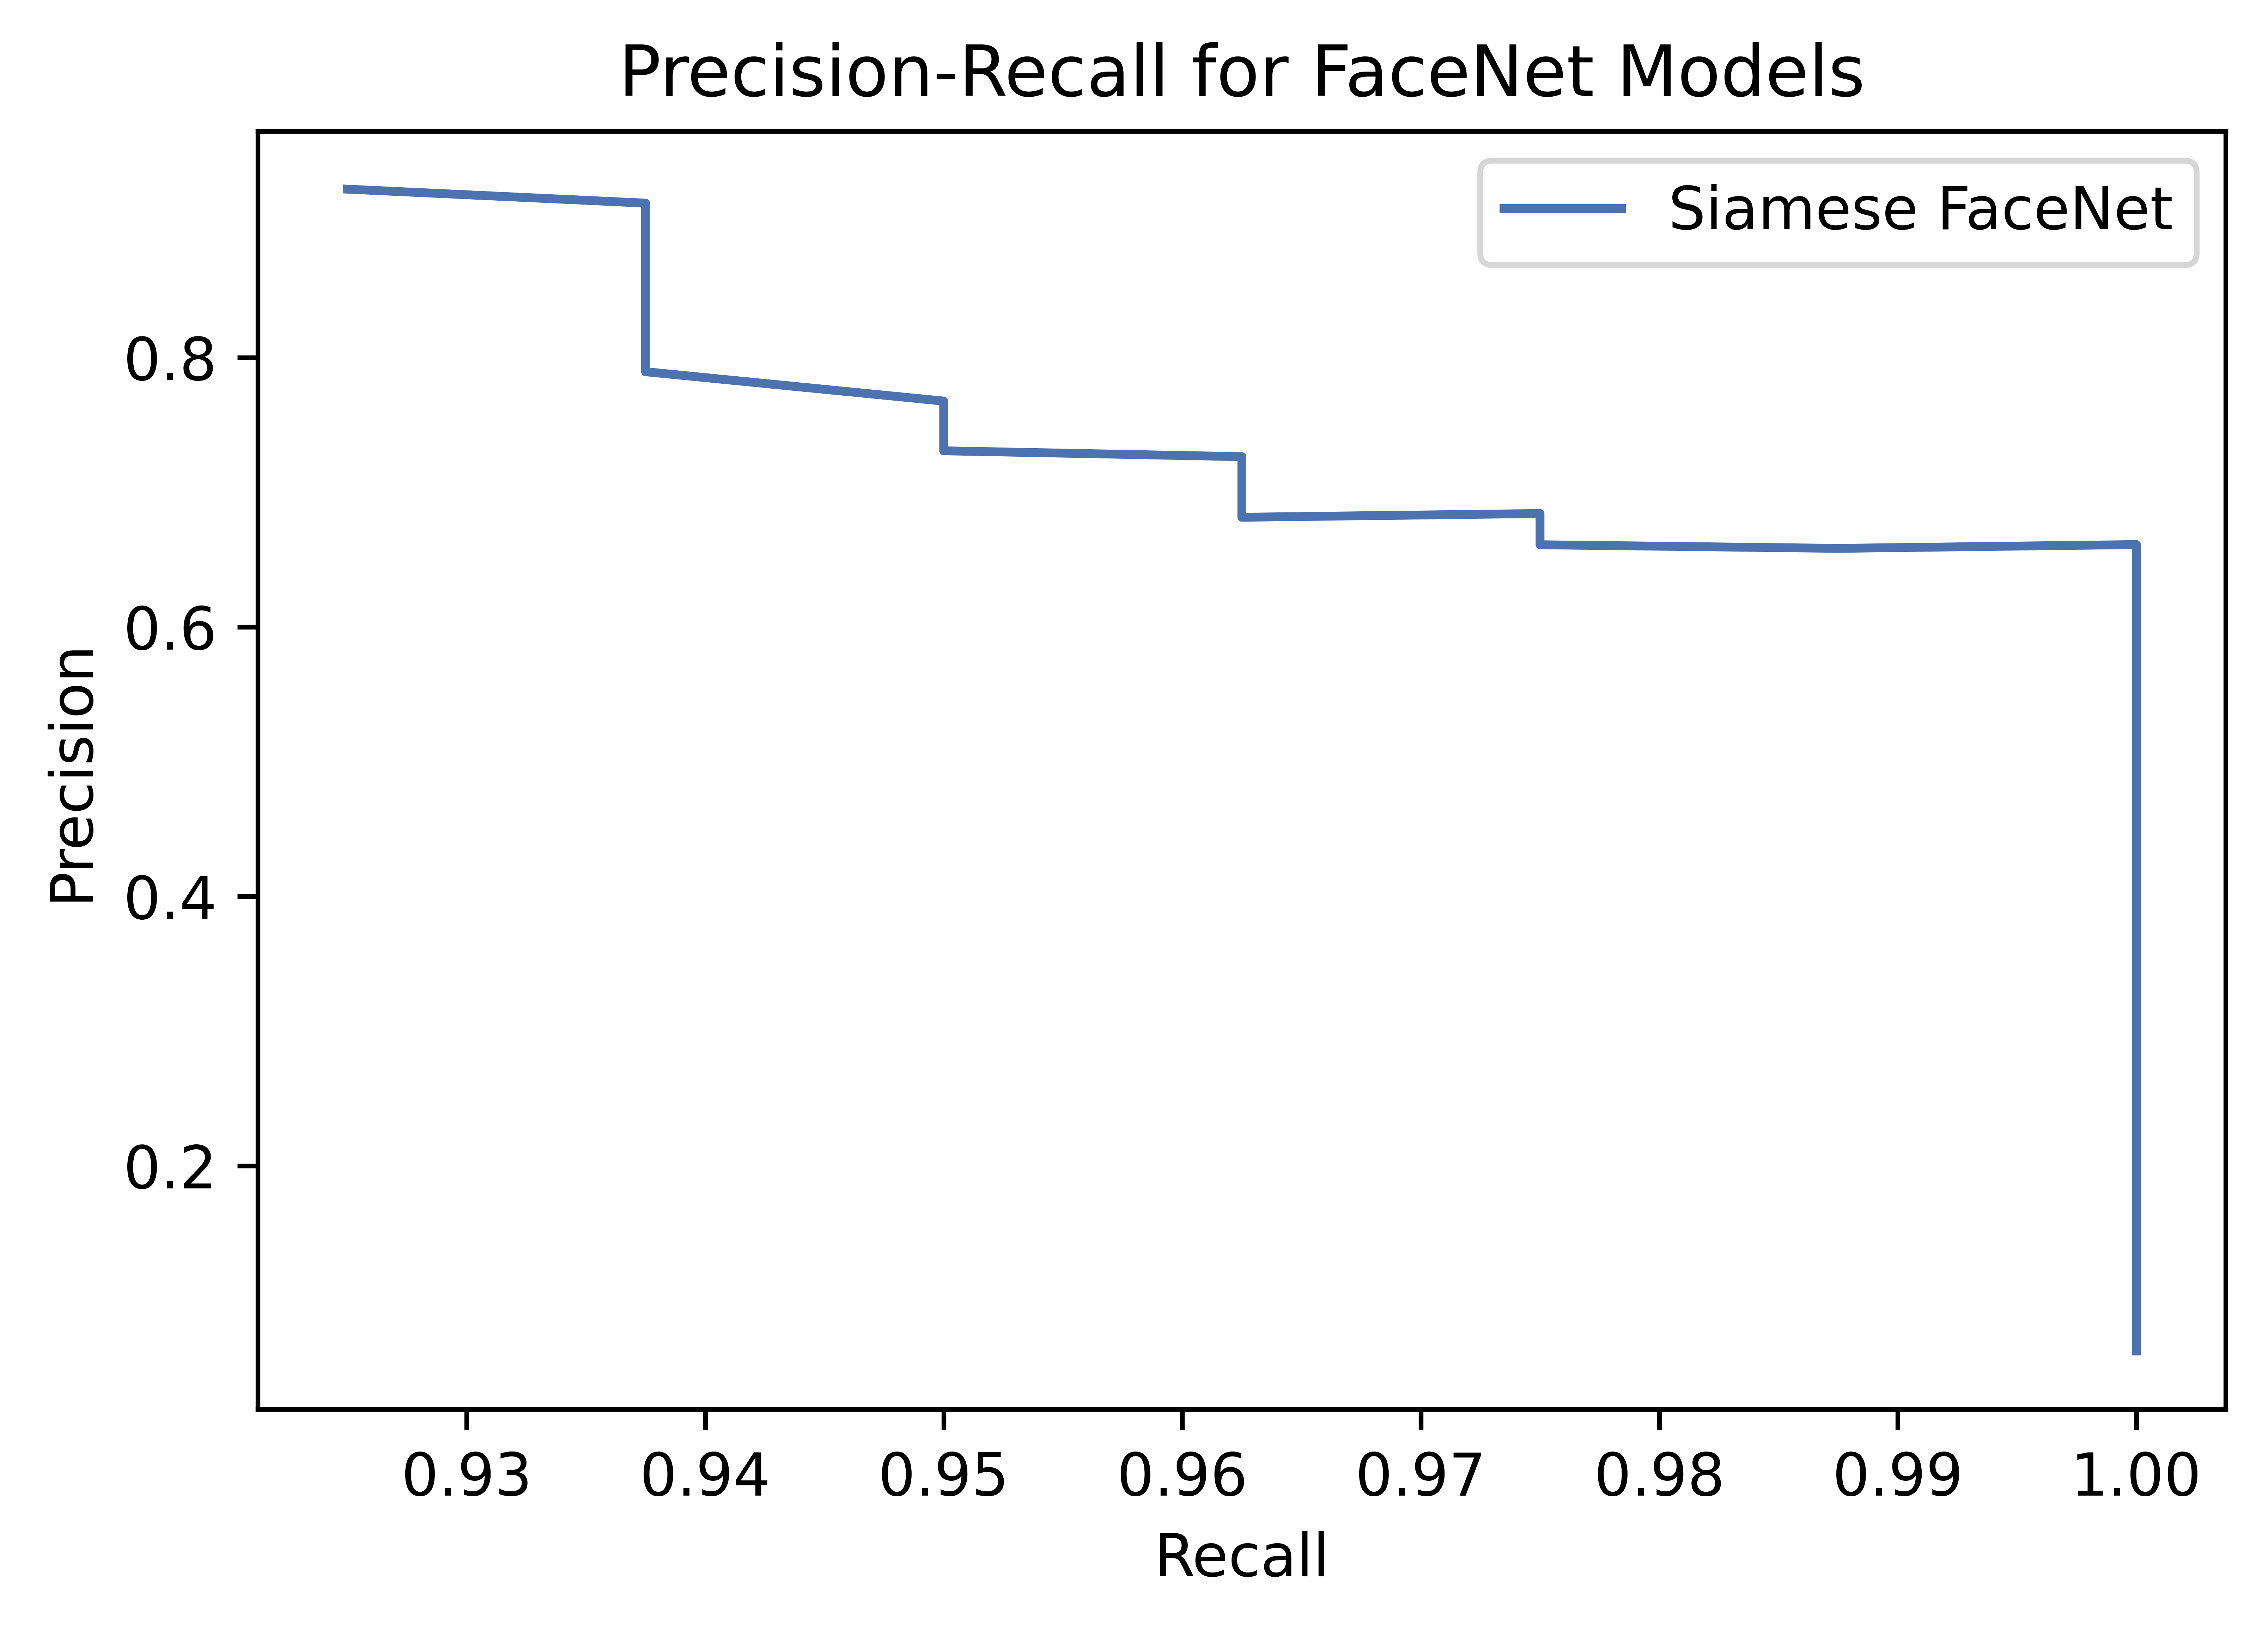

In [578]:
# plot lines
plt.figure(dpi = 1200)
plt.style.use('seaborn-deep')
name =  "Siamese "+model_name
plt.plot( rec, pre, label = name)
#plt.plot( rec2, pre2, label = model_name)


plt.xlabel("Recall")
plt.ylabel("Precision")
title =  "Precision-Recall for "+model_name+" Models"
plt.title(title)
plt.legend()
plt.show()

### Calculating FAR, FRR and EER curve

In [613]:
f = np.add(fp_array,tn_array)
far = np.divide(fp_array,f)

In [614]:
f = np.add(fn_array,tp_array)
frr = np.divide(fn_array,f)

In [615]:
threshold_list = []
for idx in range(0,len(fp_array)):
    threshold_list.append(idx*THRESHOLD_STEP)
threshold_array = np.array(threshold_list)

In [616]:
min_dif = 100
EER = 0
i = 0
for idx in range(0,len(frr)):
        a = frr[idx]
        b = far[idx]
        dif = abs(a-b)
        if dif <= min_dif:
            min_dif = dif
            EER = a+b/2
            threshold_value = idx*THRESHOLD_STEP
            i = idx
print('EER = ',EER)
print('threshold_value = ',threshold_value)
print('Index = ',i)

EER =  0.03964365256124722
threshold_value =  0.29
Index =  29


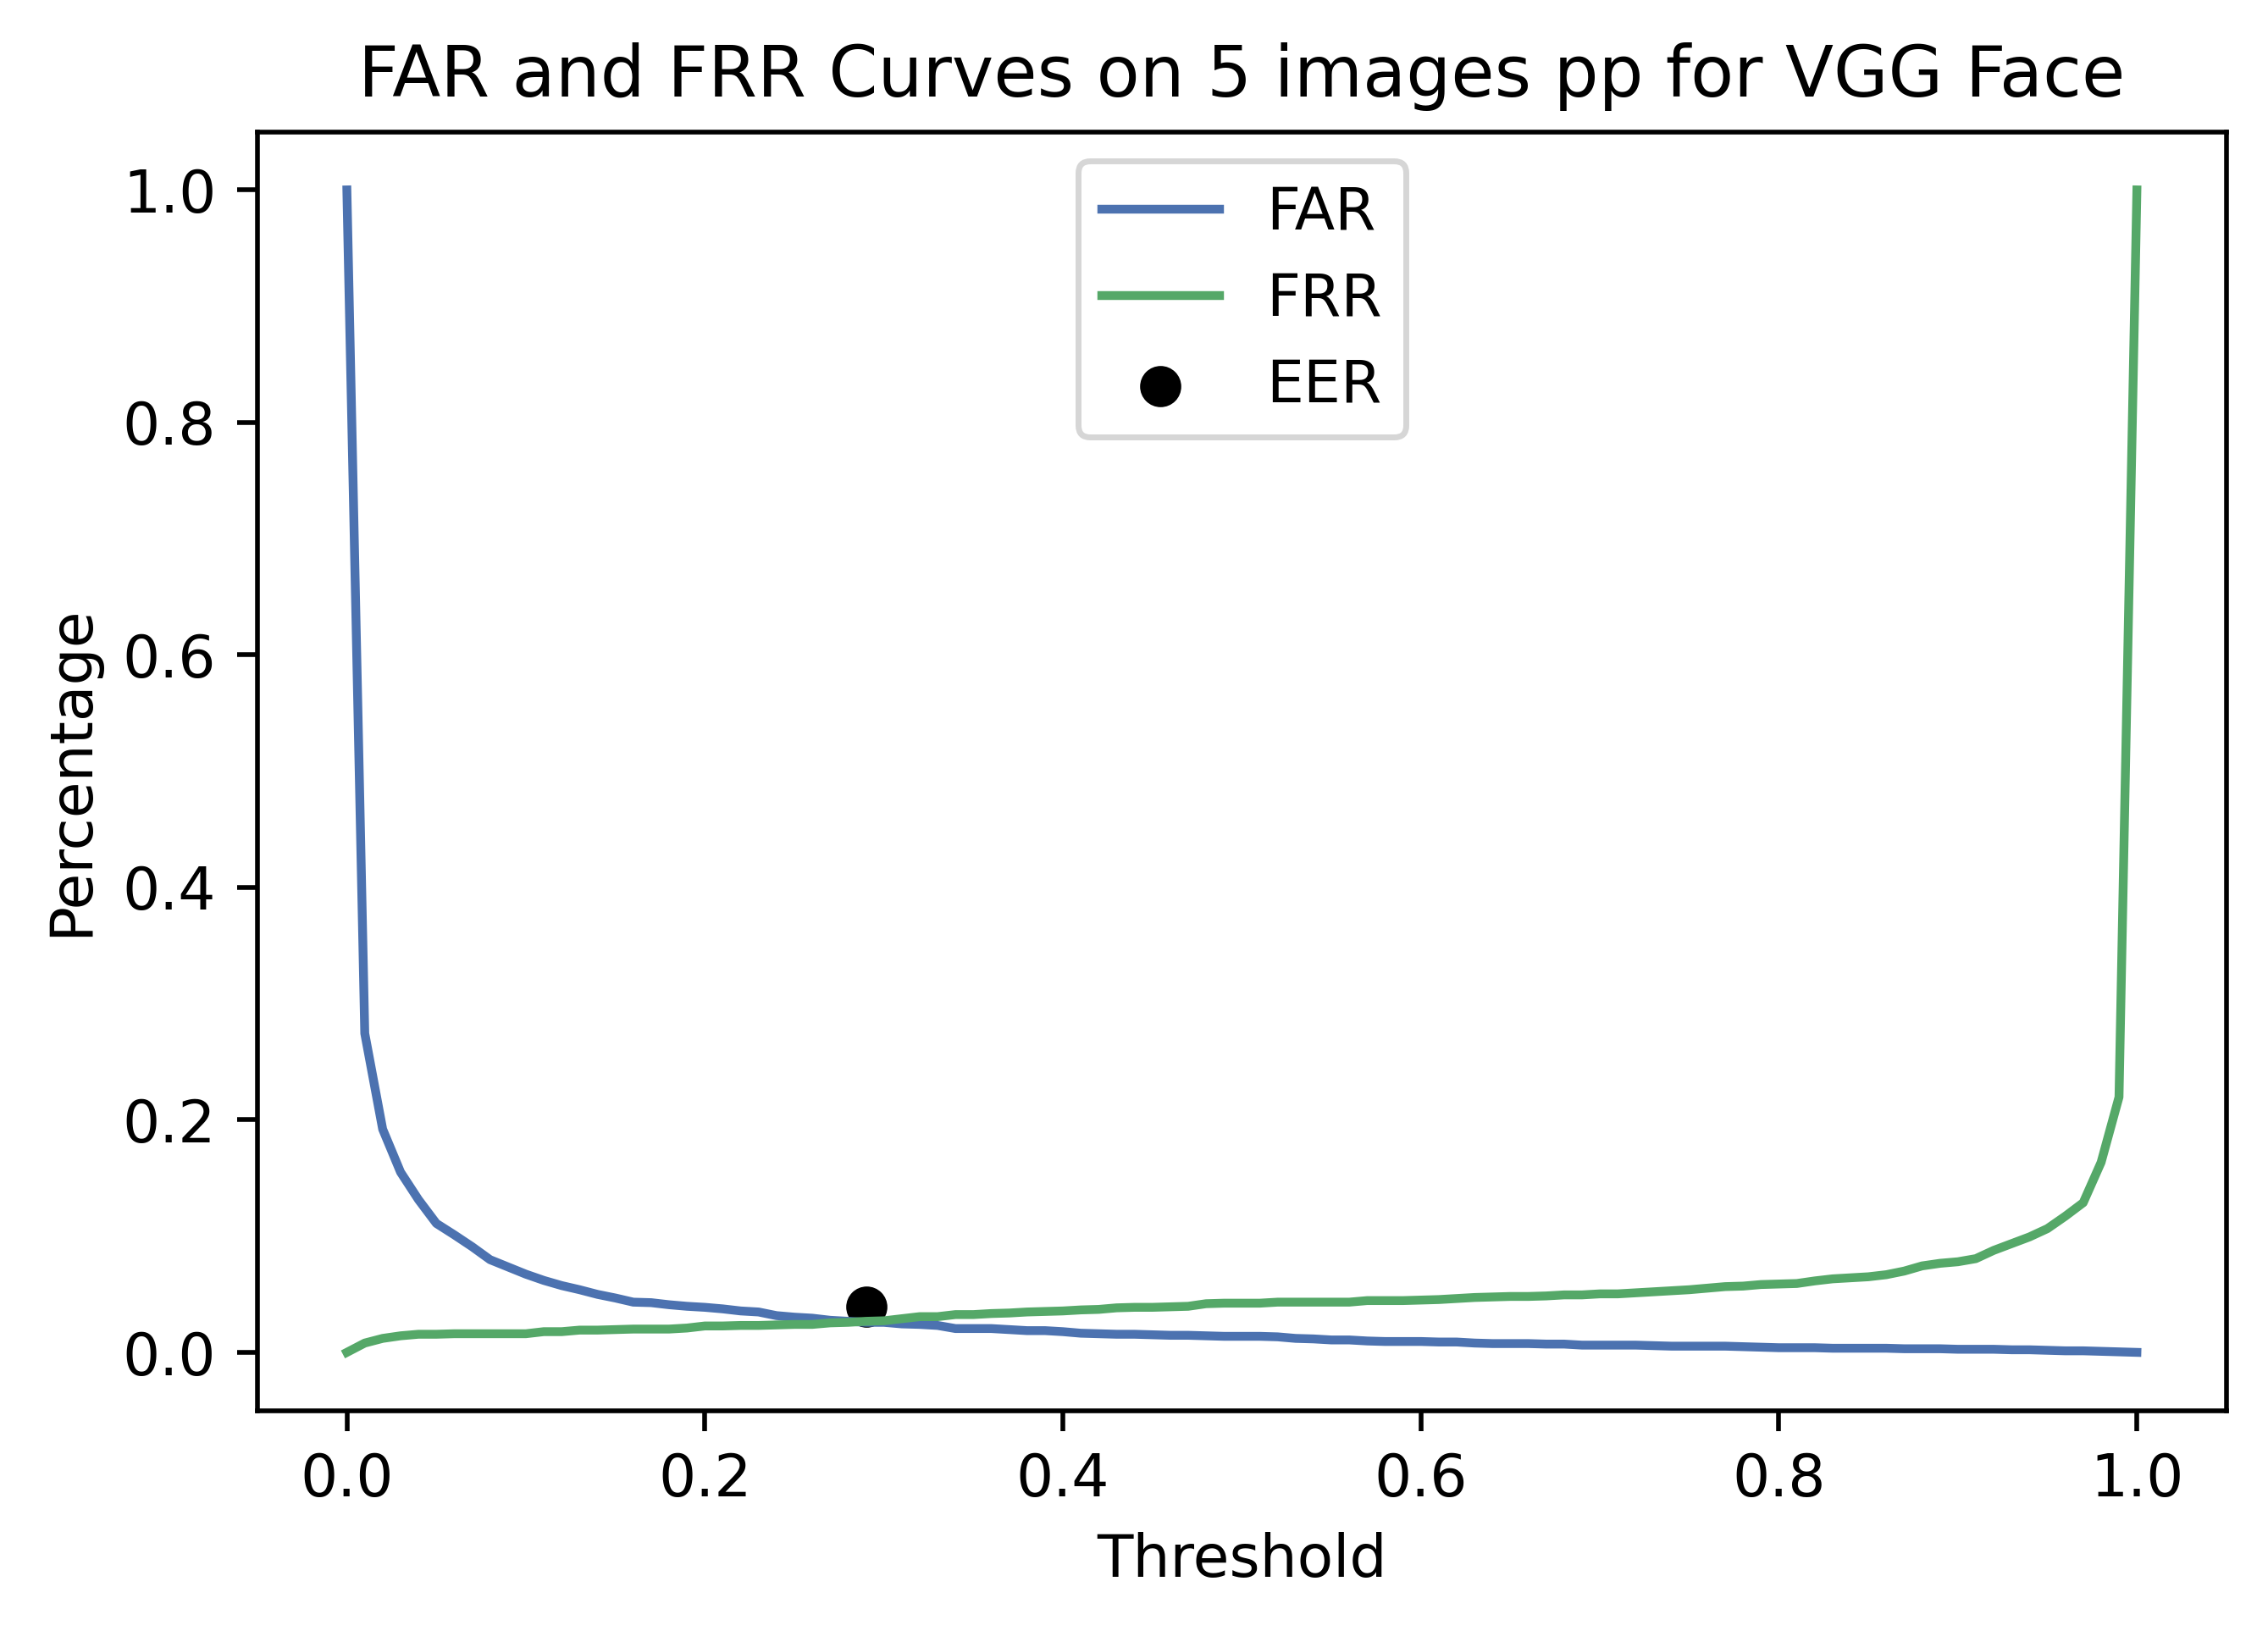

In [617]:
# plot lines
plt.figure(dpi = 500)
plt.style.use('seaborn-deep')

plt.plot( threshold_array, far, label = "FAR")
plt.plot( threshold_array, frr, label = "FRR")
plt.scatter( threshold_value, EER,color='black', label = "EER")
# only one line may be specified; full height
#plt.axhline(y = 0.03, color = 'r', linestyle = '-')

plt.xlabel("Threshold")
plt.ylabel("Percentage")
plt.title("FAR and FRR Curves on 5 images pp for VGG Face")
plt.legend()
plt.show()

In [ ]:
far1 = far

In [ ]:
far2 = far

In [ ]:
far3 = far

In [ ]:
# plot lines
plt.figure(dpi = 500)
plt.style.use('seaborn-deep')

plt.plot(threshold_array, far1, label = "1 image pp")
plt.plot(threshold_array, far2, label = "5 images pp")
plt.plot(threshold_array, far3, label = "all images")


plt.xlabel("Threshold")
plt.ylabel("Percentage")
plt.title("FAR Curves")
plt.legend()
plt.show()

### Calculating F1 measure

In [619]:
#i is the threshold we set
i = 29

In [621]:
value = i
F1 = (tp_array[value])/(tp_array[value]+0.5*(fp_array[value]+fn_array[value]))

In [622]:
far[value]

0.025835189309576838

In [623]:
fp_precentage = fp_array[value]/(fp_array[value]+tn_array[value])
fp_precentage*100

6.104166666666667

In [624]:
F1*100

68.59592711682744

In [625]:
recall = tp_array[value]/(tp_array[value]+fn_array[value])
recall

1.0

In [626]:
precision = tp_array[value]/(tp_array[value]+fp_array[value])
precision*100

52.20228384991843